In [22]:
# first we need a bit of import boilerplate
import os
import pickle as pkl
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from pathlib import Path
import json
from IPython.display import display
from PIL import Image
from tqdm import tqdm
from neo import SpikeTrain
import quantities as pq
import warnings
from elephant.gpfa import GPFA
from sklearn.model_selection import cross_val_score

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import (
    EcephysSession, 
    removed_unused_stimulus_presentation_columns
)
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

/var/folders/x1/kctky5lj58xftczlyf92pxcc0000gn/T/ipykernel_3068/2437169692.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [23]:
output_dir = os.path.expanduser("~/ecephys/data")
resources_dir = Path.cwd().parent / 'resources'
DOWNLOAD_LFP = False

# Obtain session data

In [24]:
# Example cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join(output_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [25]:
session_id = 756029989 # for example
session = cache.get_session_data(session_id)

/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [26]:
session.units.head()

/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached names

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,L_ratio,local_index,max_drift,nn_hit_rate,nn_miss_rate,peak_channel_id,presence_ratio,waveform_recovery_slope,waveform_repolarization_slope,silhouette_score,snr,waveform_spread,waveform_velocity_above,waveform_velocity_below,waveform_duration,filtering,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,structure_acronym,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
951814884,0.522713,187.434780,0.042404,6,463.86,3.555518,9.492176,0.181638,46.750473,0.024771,5,45.64,0.727333,0.016202,850126382,0.99,-0.249885,0.673650,0.033776,3.342535,40.0,0.000000,0.000000,0.151089,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,4,43,760640083,60,APN,215.0,APN,8162.0,3487.0,6737.0,probeA,See electrode locations,29999.949611,1249.9979,True
951814876,0.652514,129.686505,0.097286,5,325.21,4.445414,39.100557,0.004799,85.178750,0.001785,4,40.68,1.000000,0.003756,850126382,0.99,-0.143762,0.518633,0.108908,2.589717,50.0,0.000000,0.000000,0.315913,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,4,43,760640083,60,APN,215.0,APN,8162.0,3487.0,6737.0,probeA,See electrode locations,29999.949611,1249.9979,True
951815032,0.484297,207.380940,0.015482,17,396.28,3.848256,28.383277,0.007099,89.608836,0.035654,15,40.01,0.986000,0.014673,850126398,0.99,-0.255492,0.766347,0.096715,3.811566,80.0,-0.206030,-0.686767,0.164824,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,12,43,760640083,140,APN,215.0,APN,8129.0,3419.0,6762.0,probeA,See electrode locations,29999.949611,1249.9979,True
951815275,0.600600,158.158650,0.063807,30,374.82,3.065938,5.709358,0.032317,48.114336,0.016783,27,33.32,0.883598,0.003683,850126416,0.99,-0.206676,0.628944,0.144249,2.918134,60.0,0.686767,0.000000,0.178559,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,21,11,760640083,220,APN,215.0,APN,8095.0,3349.0,6787.0,probeA,See electrode locations,29999.949611,1249.9979,True
951815314,0.459025,173.475705,0.072129,34,420.05,4.198612,23.902235,0.048075,76.916334,0.009666,31,42.80,0.968000,0.017600,850126420,0.99,-0.171503,0.740222,0.111106,3.360324,90.0,-0.068677,-0.274707,0.178559,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,23,27,760640083,240,APN,215.0,APN,8088.0,3333.0,6792.0,probeA,See electrode locations,29999.949611,1249.9979,True


# Get the right units data

In [27]:
print(f'{session.units.shape[0]} units total')
quality_units = session.units[
    (session.units['snr'] > 4)
    &(session.units['isi_violations'] < 0.2)]
print(f'{quality_units.shape[0]} are of acceptable quality')

684 units total
75 are of acceptable quality


In [28]:
session.stimulus_presentations.head()

/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


,stimulus_block,start_time,stop_time,color,y_position,phase,x_position,orientation,frame,stimulus_name,temporal_frequency,contrast,spatial_frequency,size,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,24.429348,84.496188,null,null,null,null,null,null,spontaneous,null,null,null,null,60.066840,0
1,0.0,84.496188,84.729704,null,30.0,"[3644.93333333, 3644.93333333]",40.0,45.0,null,gabors,4.0,0.8,0.08,"[20.0, 20.0]",0.233516,1
2,0.0,84.729704,84.979900,null,10.0,"[3644.93333333, 3644.93333333]",-30.0,45.0,null,gabors,4.0,0.8,0.08,"[20.0, 20.0]",0.250196,2
3,0.0,84.979900,85.230095,null,-10.0,"[3644.93333333, 3644.93333333]",10.0,90.0,null,gabors,4.0,0.8,0.08,"[20.0, 20.0]",0.250196,3
4,0.0,85.230095,85.480291,null,40.0,"[3644.93333333, 3644.93333333]",30.0,90.0,null,gabors,4.0,0.8,0.08,"[20.0, 20.0]",0.250196,4


In [29]:
units = cache.get_units()
units.head()

,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cumulative_drift,d_prime,waveform_duration,ecephys_channel_id,firing_rate,waveform_halfwidth,isi_violations,isolation_distance,L_ratio,max_drift,nn_hit_rate,nn_miss_rate,presence_ratio,waveform_recovery_slope,waveform_repolarization_slope,silhouette_score,snr,waveform_spread,waveform_velocity_above,waveform_velocity_below,ecephys_probe_id,local_index,probe_horizontal_position,probe_vertical_position,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,ecephys_structure_id,ecephys_structure_acronym,ecephys_session_id,lfp_sampling_rate,name,phase,sampling_rate,has_lfp_data,date_of_acquisition,published_at,specimen_id,session_type,age_in_days,sex,genotype
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
915956282,0.611816,164.878740,0.072728,309.71,3.910873,0.535678,850229419,6.519432,0.164824,0.104910,30.546900,0.013865,27.10,0.898126,0.001599,0.99,-0.087545,0.480915,0.102369,1.911839,30.0,0.000000,NaN,733744647,3,27,40,NaN,NaN,NaN,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956340,0.439372,247.254345,0.000881,160.24,5.519024,0.563149,850229419,9.660554,0.206030,0.006825,59.613182,0.000410,7.79,0.987654,0.000903,0.99,-0.104196,0.704522,0.197458,3.357908,30.0,0.000000,NaN,733744647,3,27,40,NaN,NaN,NaN,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956345,0.500520,251.275830,0.001703,129.36,3.559911,0.521943,850229419,12.698430,0.192295,0.044936,47.805714,0.008281,11.56,0.930000,0.004956,0.99,-0.153127,0.781296,0.138827,3.362198,30.0,0.343384,NaN,733744647,3,27,40,NaN,NaN,NaN,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956349,0.424620,177.115380,0.096378,169.29,2.973959,0.508208,850229419,16.192413,0.192295,0.120715,54.635515,0.010406,14.87,0.874667,0.021636,0.99,-0.086022,0.553393,0.136901,2.684636,40.0,0.206030,NaN,733744647,3,27,40,NaN,NaN,NaN,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt
915956356,0.512847,214.954545,0.054706,263.01,2.936851,0.549414,850229419,2.193113,0.233501,0.430427,18.136302,0.061345,18.37,0.637363,0.000673,0.99,-0.106051,0.632977,0.108867,2.605408,60.0,-0.451304,NaN,733744647,3,27,40,NaN,NaN,NaN,8.0,grey,732592105,1249.996475,probeB,3a,29999.915391,True,2019-01-09T00:26:20Z,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt


In [30]:
# There are quite a few of these
print(units.shape[0])

40010


In [31]:
session.stimulus_names # just the unique values from the 'stimulus_name' column

['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes']

In [32]:
session.get_stimulus_epochs()

,start_time,stop_time,duration,stimulus_name,stimulus_block
0,24.429348,84.496188,60.066840,spontaneous,null
1,84.496188,996.491813,911.995625,gabors,0.0
2,996.491813,1285.483398,288.991585,spontaneous,null
3,1285.483398,1583.982946,298.499548,flashes,1.0
4,1583.982946,1585.734418,1.751472,spontaneous,null
5,1585.734418,2185.235561,599.501143,drifting_gratings,2.0
6,2185.235561,2216.261498,31.025937,spontaneous,null
7,2216.261498,2816.763498,600.502000,natural_movie_three,3.0
8,2816.763498,2846.788598,30.025100,spontaneous,null
9,2846.788598,3147.039578,300.250980,natural_movie_one,4.0


In [33]:
session.get_stimulus_table(['drifting_gratings']).head()


,stimulus_block,start_time,stop_time,phase,orientation,stimulus_name,temporal_frequency,contrast,spatial_frequency,size,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,2.0,1585.734418,1587.736098,"[42471.86666667, 42471.86666667]",180.0,drifting_gratings,2.0,0.8,0.04,"[250.0, 250.0]",2.00168,246
3799,2.0,1588.736891,1590.738571,"[42471.86666667, 42471.86666667]",135.0,drifting_gratings,2.0,0.8,0.04,"[250.0, 250.0]",2.00168,247
3800,2.0,1591.739398,1593.741078,"[42471.86666667, 42471.86666667]",180.0,drifting_gratings,2.0,0.8,0.04,"[250.0, 250.0]",2.00168,246
3801,2.0,1594.741921,1596.743591,"[42471.86666667, 42471.86666667]",270.0,drifting_gratings,2.0,0.8,0.04,"[250.0, 250.0]",2.00167,248
3802,2.0,1597.744458,1599.746088,"[42471.86666667, 42471.86666667]",135.0,drifting_gratings,4.0,0.8,0.04,"[250.0, 250.0]",2.00163,249


In [34]:
for key, values in session.get_stimulus_parameter_values().items():
    print(f'{key}: {values}')

color: [-1.0 1.0]
y_position: [30.0 10.0 -10.0 40.0 -40.0 -20.0 0.0 20.0 -30.0]
phase: ['[3644.93333333, 3644.93333333]' '[0.0, 0.0]'
 '[42471.86666667, 42471.86666667]' '0.0' '0.25' '0.5' '0.75']
x_position: [40.0 -30.0 10.0 30.0 0.0 -40.0 -20.0 -10.0 20.0]
orientation: [45.0 90.0 0.0 180.0 135.0 270.0 315.0 225.0 30.0 150.0 120.0 60.0]
frame: [0.0 1.0 2.0 ... 3598.0 3599.0 -1.0]
temporal_frequency: [4.0 2.0 15.0 1.0 8.0]
contrast: [0.8 1.0]
spatial_frequency: ['0.08' '[0.0, 0.0]' '0.04' 0.08 0.04 0.32 0.02 0.16]
size: ['[20.0, 20.0]' '[300.0, 300.0]' '[250.0, 250.0]' '[1920.0, 1080.0]']


In [35]:
 # grab an arbitrary (though high-snr!) unit (we made units_with_high_snr above)
quality_unit_ids = quality_units.index.values
unit_id = quality_unit_ids[0]

print(f"{len(session.spike_times[unit_id])} spikes were detected for unit {unit_id} at times:")
session.spike_times[unit_id]

236169 spikes were detected for unit 951816951 at times:


array([3.81328401e+00, 4.20301799e+00, 4.30151816e+00, ...,
       9.96615988e+03, 9.96617945e+03, 9.96619655e+03])

# Store unit spike train data, get trajectories

In [39]:
from neo.core import SpikeTrain
import quantities as pq
from tqdm import tqdm


In [40]:

# get spike times from the drifting gratings presentations 
drifting_gratings_presentation_ids = session.stimulus_presentations.loc[
    (session.stimulus_presentations['stimulus_name'] == 'drifting_gratings')
].index.values

times = session.presentationwise_spike_times(
    stimulus_presentation_ids=drifting_gratings_presentation_ids,
    unit_ids=quality_unit_ids
)

# sort the spikes in stimulus_presentation_id, units, and time_since_stimulus_onset.
# In other words, we sort individual presentation data by unit chronologically
sorted_spikes=times.sort_values(by=['stimulus_presentation_id','unit_id','time_since_stimulus_presentation_onset'])

# get all stimulus presentation ids
stims = sorted_spikes['stimulus_presentation_id'].unique()

In [40]:

spike_train_trials = []

N_trials = 10

# get spike trains for the given ids
for stim in tqdm(stims[:N_trials],desc=f'Getting spike trains for {N_trials} drifting_grating stimulus trials'):
    spike_trains = []
    for unit_id in tqdm(sorted_spikes['unit_id'].unique(), 
                        desc = 'Getting individual spike trains for each unit in trial',
                        leave = False):
        # Get spike train for the unit during the presented stimulus
        df_spike_train = sorted_spikes[
            (sorted_spikes['stimulus_presentation_id']==stim)
            &(sorted_spikes['unit_id']==unit_id)]
        # Get the start and stop time for the spike train
        t_start = session.get_stimulus_table().loc[stim]['start_time']
        t_stop = session.get_stimulus_table().loc[stim]['stop_time']
        # Store spike train in neo.SpikeTrain instance, append to the spike trains for the trial
        spike_trains.append(SpikeTrain(times=df_spike_train.index.to_numpy(),
                                       t_start=t_start,
                                       t_stop=t_stop,
                                       units=pq.s))
    # Append trial spike trains to the full list of trials
    spike_train_trials.append(spike_trains)

Getting spike trains for 10 drifting_grating stimulus trials: 100%|██████████| 10/10 [07:48<00:00, 46.83s/it]


(54,)


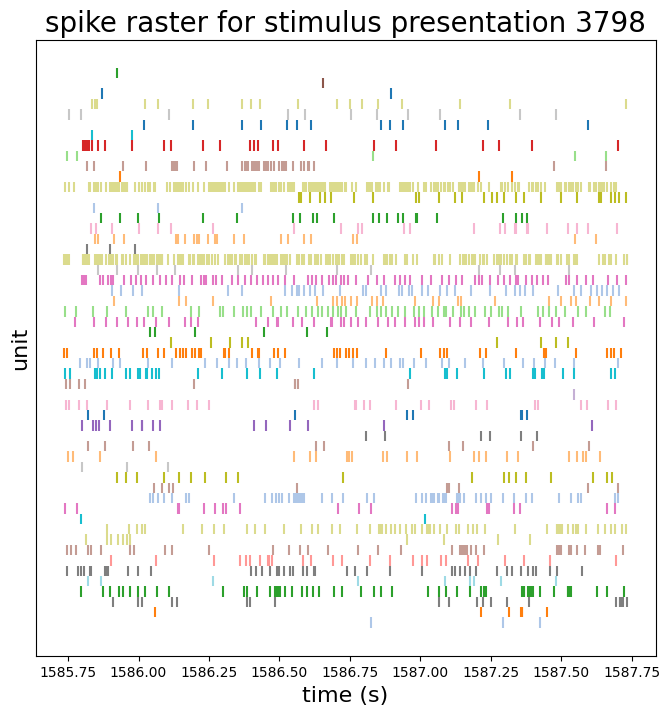

In [41]:
first_drifting_grating_presentation_id = times['stimulus_presentation_id'].values[0]
plot_times = times[times['stimulus_presentation_id'] == first_drifting_grating_presentation_id]
print(plot_times['unit_id'].unique().shape)
fig = raster_plot(plot_times, title=f'spike raster for stimulus presentation {first_drifting_grating_presentation_id}')
plt.show()

In [45]:
times.to_csv('../data/processed/quality_spike_times_drifting_gratings.csv')

In [46]:
with open('../data/processed/spike_train_trials_drifting_gratings.pkl','wb') as f:
    pkl.dump(spike_train_trials,f)

# GPFA on Spike Trains

In [12]:
with open('../data/processed/spike_train_trials_drifting_gratings.pkl','rb') as f:
    spike_train_trials = pkl.load(f)

In [13]:
with warnings.catch_warnings(action='ignore'):
    # We will select best x_dim based on log likelihood
    x_dims = range(1,20)
    log_likelihoods = []
    for x_dim in tqdm(x_dims, desc='Testing best dimensions n for GPFA'):
        gpfa_cv = GPFA(bin_size=20*pq.ms, x_dim=x_dim)
        # estimate the log-likelihood for the given dimensionality as the mean of the log-likelihoods from 3 cross-vailidation folds
        cv_log_likelihoods = cross_val_score(gpfa_cv, spike_train_trials, cv=3, n_jobs=3, verbose=True)
        log_likelihoods.append(np.mean(cv_log_likelihoods))

Testing best dimensions n for GPFA:   0%|          | 0/19 [00:00<?, ?it/s][Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  wa

Initializing parameters using factor analysis...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Fitting has converged after 320 EM iterations.)
Fitting has converged after 345 EM iterations.)
Fitting has converged after 355 EM iterations.)


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.p

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...
Initializing parameters using factor analysis...

Fitting GPFA model...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...
Initializing parameters using factor analysis...

Fitting GPFA model...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...
Initializing parameters using factor analysis...

Fitting GPFA model...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...
Initializing parameters using factor analysis...

Fitting GPFA model...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...
Initializing parameters using factor analysis...

Fitting GPFA model...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:113

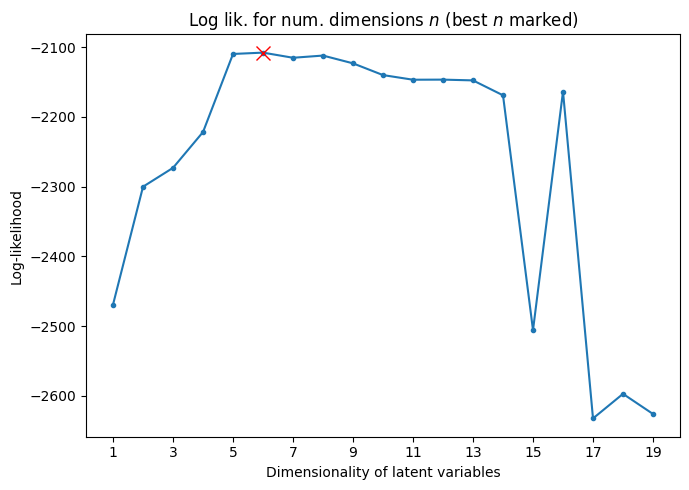

In [14]:
f = plt.figure(figsize=(7, 5))
plt.title('Log lik. for num. dimensions $n$ (best $n$ marked)')
plt.xlabel('Dimensionality of latent variables')
plt.ylabel('Log-likelihood')
plt.xticks(np.arange(1,20,2))
plt.plot(x_dims, log_likelihoods, '.-')
plt.plot(x_dims[np.argmax(log_likelihoods)], np.max(log_likelihoods), 'x', markersize=10, color='r')
plt.tight_layout()
plt.show()

In [15]:
gpfa_best_dim = GPFA(bin_size=20*pq.ms, x_dim=6)
gpfa_spike_train_trials = gpfa_best_dim.fit_transform(spiketrains=spike_train_trials)

/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...


/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/elephant/conversion.py:1130: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


In [16]:
import pickle as pkl

with open('../data/gpfa_spike_data.pkl','wb') as f:
    pkl.dump(gpfa_spike_train_trials,f)


Text(0.5, 0, 'Time (s) since Stimulus Onset')

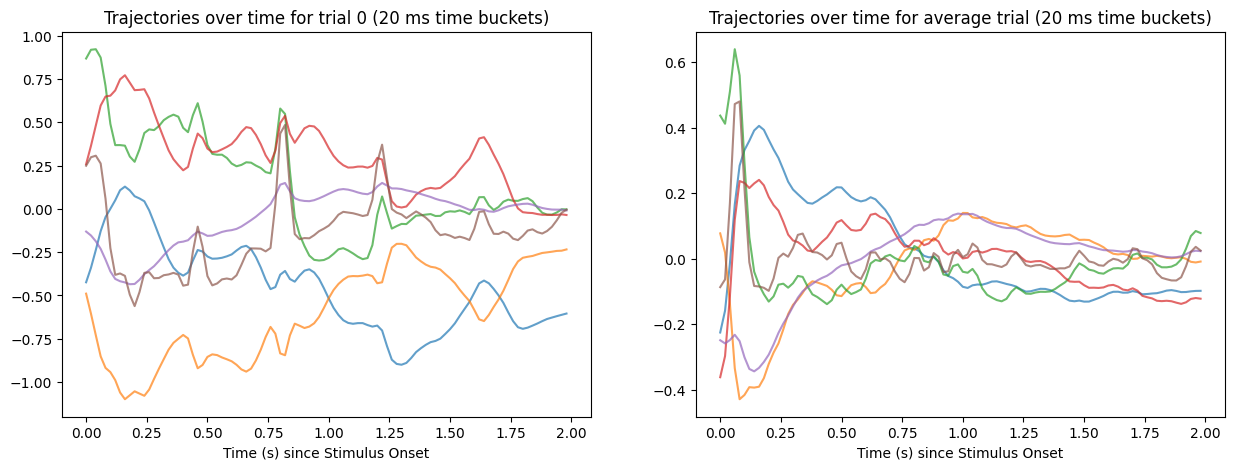

In [17]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))

for traj in gpfa_spike_train_trials[0]:
    ax1.plot(np.arange(0,2,0.02), traj, alpha=0.7)
ax1.set_title('Trajectories over time for trial 0 (20 ms time buckets)')
ax1.set_xlabel('Time (s) since Stimulus Onset')

for traj in gpfa_spike_train_trials.mean():
    ax2.plot(np.arange(0,2,0.02), traj, alpha=0.7)
ax2.set_title('Trajectories over time for average trial (20 ms time buckets)')
ax2.set_xlabel('Time (s) since Stimulus Onset')

In [37]:
traj_data

array([array([[-4.23945083e-01, -3.40352213e-01, -2.37408466e-01,
               -1.28546572e-01, -4.73429377e-02,  5.47331397e-04,
                4.96107875e-02,  1.07577680e-01,  1.28513130e-01,
                1.06648312e-01,  7.29334709e-02,  6.01871608e-02,
                4.38328057e-02, -8.87668218e-03, -7.88058249e-02,
               -1.51673719e-01, -2.22328824e-01, -2.90432164e-01,
               -3.39534507e-01, -3.68985891e-01, -3.85547668e-01,
               -3.67788964e-01, -2.98856630e-01, -2.37490914e-01,
               -2.46421534e-01, -2.74926891e-01, -2.87900602e-01,
               -2.86752682e-01, -2.82512085e-01, -2.74048267e-01,
               -2.63035430e-01, -2.40540115e-01, -2.20423942e-01,
               -2.13179033e-01, -2.32501074e-01, -2.78850540e-01,
               -3.39224025e-01, -4.09274311e-01, -4.63419045e-01,
               -4.51703508e-01, -3.80050893e-01, -3.58553056e-01,
               -4.05114055e-01, -4.20388165e-01, -3.85155041e-01,
          

In [42]:
times

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
1585.734841,3798,951817927,0.000423
1585.736862,3798,951812742,0.002444
1585.738591,3798,951805427,0.004173
1585.738941,3798,951816951,0.004523
1585.738995,3798,951820510,0.004577
...,...,...,...
5397.923611,49432,951817589,1.987420
5397.927021,49432,951807639,1.990830
5397.930712,49432,951818431,1.994521
